In [7]:
%pip install pydriller tqdm --break-system-packages

Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: Loading egg at /usr/local/lib/python3.13/dist-packages/CSXCAD-0.6.2-py3.13-linux-x86_64.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /usr/local/lib/python3.13/dist-packages/openEMS-0.0.36-py3.13-linux-x86_64.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
Note: you may need to restart the kernel to use updated packages.


## Activity (a): Repository Selection

In [2]:
# Just placeholders, replace with your chosen repos (must NOT be ones used in Lab 2/3)
repos = [
    "https://github.com/1Password/for-open-source",
    "https://github.com/11ty/eleventy",
    "https://github.com/24pullrequests/24pullrequests"
]

repos


['https://github.com/1Password/for-open-source',
 'https://github.com/11ty/eleventy',
 'https://github.com/24pullrequests/24pullrequests']

## Activity (c): Run Software Tool (pydriller + diff algorithms)

In [ ]:
from pydriller import Repository
import os
import csv
from tqdm import tqdm
import pandas as pd
import git  # GitPython

# Output CSV file
output_file = "lab4_diffs_raw.csv"
fieldnames = [
    "old_file", "new_file", "commit_sha",
    "parent_sha", "commit_message",
    "diff_myers", "diff_hist"
]

with open(output_file, "w", newline="", encoding="utf-8", error="replace") as f:
    writer = csv.DictWriter(f, fieldnames=fieldnames)
    writer.writeheader()

    for repo_url in repos:
        repo_name = repo_url.split("/")[-1]
        repo_path = f"./cloned_repos/{repo_name}"

        # Clone if not already present
        if not os.path.exists(repo_path):
            os.system(f"git clone {repo_url} {repo_path}")

        # Initialize GitPython repo object
        git_repo = git.Repo(repo_path)

        # Traverse commits
        for commit in tqdm(Repository(repo_path).traverse_commits(),
                           desc=f"Processing {repo_name}", unit="commit"):

            if not commit.parents:  # skip root commits
                continue

            parent_sha = commit.parents[0]

            for mf in commit.modified_files:
                file_path = mf.new_path or mf.old_path
                try:
                    # Myers diff directly from PyDriller
                    diff_myers = mf.diff

                    # Histogram diff from GitPython
                    try:
                        diff_hist = git_repo.git.diff(
                            parent_sha, commit.hash,
                            "--", file_path,
                            diff_algorithm="histogram"
                        )
                    except Exception as e:
                        diff_hist = f"Error computing hist diff: {e}"

                    row = {
                        "old_file": mf.old_path,
                        "new_file": mf.new_path,
                        "commit_sha": commit.hash,
                        "parent_sha": parent_sha,
                        "commit_message": commit.msg,
                        "diff_myers": diff_myers,
                        "diff_hist": diff_hist
                    }
                    writer.writerow(row)

                except Exception as e:
                    print("Error:", e)

print(f"Finished. Results saved to {output_file}")
df = pd.read_csv(output_file)


Cloning into './cloned_repos/for-open-source'...
Processing for-open-source: 2649commit [02:44, 16.11commit/s]
Cloning into './cloned_repos/eleventy'...
Processing eleventy: 3418commit [04:28, 12.71commit/s]
Cloning into './cloned_repos/24pullrequests'...
Processing 24pullrequests: 6304commit [03:38, 28.91commit/s]

Finished. Results saved to lab4_diffs_raw_new.csv


## Activity (d): Compare Diff Outputs

In [ ]:
import pandas as pd
df = pd.read_csv("lab4_diffs_raw.csv")
df

,old_file,new_file,commit_sha,parent_sha,commit_message,diff_myers,diff_hist
0,NaN,.github/pull_request_template.md,6a4bea78199294fe509f15f8a8d3c10103bf8345,4db245826fa3201020457daac0369f57fa841216,added pull request template,diff --git a/.github/pull_request_template.md ...,diff --git a/.github/pull_request_template.md ...
1,README.md,README.md,3d93b109e7a0767fecffe5bac80e975d5eea60b9,6a4bea78199294fe509f15f8a8d3c10103bf8345,removed placeholder example,diff --git a/README.md b/README.md\nindex 4f27...,diff --git a/README.md b/README.md\nindex 4f27...
2,README.md,README.md,8394f95a7404f1f2fec3815a41b112a4a5090e48,3d93b109e7a0767fecffe5bac80e975d5eea60b9,fixed typo,diff --git a/README.md b/README.md\nindex 5c91...,diff --git a/README.md b/README.md\nindex 5c91...
3,.github/pull_request_template.md,.github/pull_request_template.md,ae08df25307b60599ac39df0f35075b0dc860bd5,8394f95a7404f1f2fec3815a41b112a4a5090e48,Added team url to PR template,diff --git a/.github/pull_request_template.md ...,diff --git a/.github/pull_request_template.md ...
4,README.md,README.md,bd1996dad88e8b24e60771d25de84a6e69e02934,ae08df25307b60599ac39df0f35075b0dc860bd5,Add project: Reddit Enhancement Suite,diff --git a/README.md b/README.md\nindex 6a74...,diff --git a/README.md b/README.md\nindex 6a74...
...,...,...,...,...,...,...,...
21048,Gemfile.lock,Gemfile.lock,8a979f84234073181ef19faf4a275ff6c240058a,f14442202583f1473f08cd8550005a45df2e6d7c,Bump connection_pool from 2.5.3 to 2.5.4\n\nBu...,diff --git a/Gemfile.lock b/Gemfile.lock\ninde...,diff --git a/Gemfile.lock b/Gemfile.lock\ninde...
21049,Gemfile.lock,Gemfile.lock,418d9269135f5a5bf73f8fdad78c19c04a85712d,f14442202583f1473f08cd8550005a45df2e6d7c,Bump oauth2 from 2.0.12 to 2.0.14\n\nBumps [oa...,diff --git a/Gemfile.lock b/Gemfile.lock\ninde...,diff --git a/Gemfile.lock b/Gemfile.lock\ninde...
21050,Gemfile.lock,Gemfile.lock,05f0a51ced1375e229c889f8cc01bac42c2fabd1,94771787856d3e79b548a7f8285fde4d6de16efc,Bump version_gem from 1.1.8 to 1.1.9\n\nBumps ...,diff --git a/Gemfile.lock b/Gemfile.lock\ninde...,diff --git a/Gemfile.lock b/Gemfile.lock\ninde...
21051,Gemfile.lock,Gemfile.lock,00ecacd40708fe989f080779b2cf3da14c685377,c039386849701db41032d5815de939181170873f,Bump bigdecimal from 3.2.2 to 3.2.3\n\nBumps [...,diff --git a/Gemfile.lock b/Gemfile.lock\ninde...,diff --git a/Gemfile.lock b/Gemfile.lock\ninde...


In [8]:
df['diff_myers'] = df['diff_myers'].fillna("")
df['diff_hist'] = df['diff_hist'].fillna("")

df['Discrepancy'] = df.apply(
    lambda row: "NO" if row['diff_myers'].strip() == row['diff_hist'].strip() else "YES",
    axis=1
)

df.to_csv("lab4_diffs_with_discrepancy.csv", index=False)
df['Discrepancy'].value_counts()


Discrepancy
NO     18434
YES     2619
Name: count, dtype: int64

## Activity (e): Final Dataset Statistics + Plots

Mismatch counts:
 category
Source    996
Test      935
Other     663
README     25
Name: count, dtype: int64


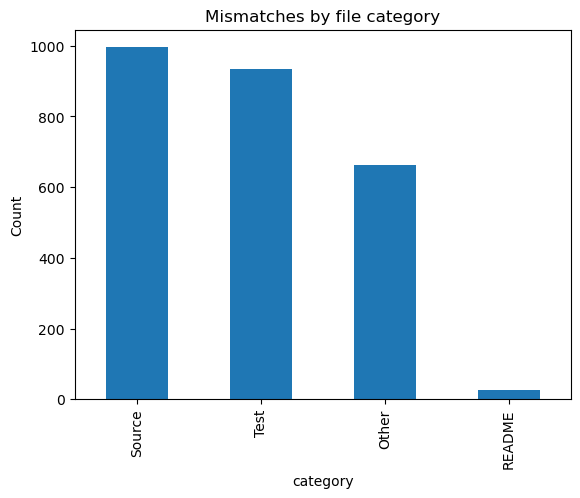

In [ ]:
import matplotlib.pyplot as plt

def file_category(filename):
    if not isinstance(filename, str):
        return "Other"
    f = filename.lower()
    if "test" in f:
        return "Test"
    elif "readme" in f:
        return "README"
    elif "license" in f:
        return "LICENSE"
    elif f.endswith((".c", ".cpp", ".py", ".java", ".h", ".hpp", ".js")):
        return "Source"
    else:
        return "Other"


df['category'] = df['new_file'].apply(file_category)

stats = df[df['Discrepancy']=="YES"]['category'].value_counts()
print("Mismatch counts:\n", stats)

# Plot
stats.plot(kind="bar", title="Mismatches by file category")
plt.ylabel("Count")
plt.show()


## Save Final Table

In [11]:
df.to_csv("lab4_final_dataset.csv", index=False)

In [3]:
import pandas as pd
df = pd.read_csv("lab4_final_dataset.csv")

In [4]:
df["diff_myers"][0]

'diff --git a/.github/pull_request_template.md b/.github/pull_request_template.md\nnew file mode 100644\nindex 0000000..0b28545\n--- /dev/null\n+++ b/.github/pull_request_template.md\n@@ -0,0 +1,30 @@\n+## Your project\n+\n+**Project name**:  \n+\n+**Short description**:\n+\n+**Project age**: \n+\n+**Number of core contributors**:\n+\n+**Project website**:\n+\n+**Repository url**:\n+\n+**Latest release url**:\n+\n+**License type**: e.g. MIT, BSD, GPL, etc\n+\n+**License url**: A copy of the license terms and conditions for your software.\n+\n+\n+## Tell us about yourself\n+\n+**Name**: \n+\n+**Email**:\n+\n+**Project role**:\n+\n+**Website**: link to GitHub profile page, project page bio, etc\n\\ No newline at end of file\n'

In [5]:
df["diff_hist"][0]

'diff --git a/.github/pull_request_template.md b/.github/pull_request_template.md\nnew file mode 100644\nindex 0000000..0b28545\n--- /dev/null\n+++ b/.github/pull_request_template.md\n@@ -0,0 +1,30 @@\n+## Your project\n+\n+**Project name**:  \n+\n+**Short description**:\n+\n+**Project age**: \n+\n+**Number of core contributors**:\n+\n+**Project website**:\n+\n+**Repository url**:\n+\n+**Latest release url**:\n+\n+**License type**: e.g. MIT, BSD, GPL, etc\n+\n+**License url**: A copy of the license terms and conditions for your software.\n+\n+\n+## Tell us about yourself\n+\n+**Name**: \n+\n+**Email**:\n+\n+**Project role**:\n+\n+**Website**: link to GitHub profile page, project page bio, etc\n\\ No newline at end of file\n'